In [1]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=7778cf38c6e003a99c5442532ff0b8b1a42eafdd3b505d8b06e0b1a134f44055
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [19]:
import pandas as pd
import numpy as np
import joblib
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras import backend as K
from keras.models import load_model
from keras.losses import MeanSquaredError as mse
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from joblib import dump, load
import json

### **: Import Orderly Kline data for preprocessing**

In [3]:
file_name = 'kline_data.json'
with open(file_name) as f:
    data = json.load(f)
rows = data['data']['rows']
df = pd.DataFrame(rows)

print(df.head(25))

       open    close      low     high   volume        amount         symbol  \
0   2413.46  2413.89  2413.46  2414.12   5.4035  13043.499641  PERP_ETH_USDC   
1   2413.95  2413.46  2413.46  2415.16   4.1856  10106.746960  PERP_ETH_USDC   
2   2413.64  2414.05  2413.39  2414.20   1.8256   4406.570048  PERP_ETH_USDC   
3   2412.88  2413.64  2412.88  2414.16   7.5311  18177.868972  PERP_ETH_USDC   
4   2411.06  2413.22  2410.47  2413.22   6.6190  15962.923982  PERP_ETH_USDC   
5   2412.36  2411.06  2410.80  2412.36  20.6984  49916.219412  PERP_ETH_USDC   
6   2412.38  2412.63  2412.38  2413.45   7.1421  17233.215061  PERP_ETH_USDC   
7   2414.17  2412.38  2412.06  2414.17   5.3857  12995.573014  PERP_ETH_USDC   
8   2413.00  2414.17  2411.54  2414.34   7.5711  18264.624609  PERP_ETH_USDC   
9   2415.02  2413.00  2412.73  2415.02   8.5842  20713.755743  PERP_ETH_USDC   
10  2416.57  2415.02  2415.02  2416.57   0.0000      0.000000  PERP_ETH_USDC   
11  2417.88  2416.57  2415.28  2418.47  

In [4]:
print(len(df))

500


In [5]:
columns_to_drop = ['start_timestamp', 'amount', 'symbol', 'type', 'volume']
# Drop the specified columns from Df
data = df.drop(columns=columns_to_drop, errors='ignore')

In [6]:
zeros = (data == 0).sum()
print('zeros', zeros)
nans = data.isna().sum()
print('nans', nans)

zeros open             0
close            0
low              0
high             0
end_timestamp    0
dtype: int64
nans open             0
close            0
low              0
high             0
end_timestamp    0
dtype: int64


In [7]:
data = data.sort_values('end_timestamp')
data.fillna(method='ffill', inplace=True)

<ipython-input-7-cdd12b3309eb>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [8]:
data.reset_index(drop=True, inplace=True)

In [9]:
data['SMA_10'] = ta.trend.sma_indicator(data['close'], window=10)
data['EMA_10'] = ta.trend.ema_indicator(data['close'], window=10)
data['RSI'] = ta.momentum.rsi(data['close'], window=14)
data['MACD'] = ta.trend.macd(data['close'])
data['Bollinger_High'] = ta.volatility.BollingerBands(data['close'], window=20, window_dev=2).bollinger_hband()
data['Bollinger_Low'] = ta.volatility.BollingerBands(data['close'], window=20, window_dev=2).bollinger_lband()

In [10]:
def create_features(data):
    data['RSI_lag1'] = data['RSI'].shift(1)
    data['RSI_lag2'] = data['RSI'].shift(2)
    data['RSI_diff'] = data['RSI'].diff()

    return data
data = create_features(data)

In [11]:
# align to training feature order
training_feature_order = [
        'open',
        'high',
        'low',
        'close',
        'SMA_10',
        'EMA_10',
        'RSI',
        'MACD',
        'Bollinger_High',
        'Bollinger_Low',
        'RSI_lag1',
        'RSI_lag2',
        'RSI_diff'
]
data = data[training_feature_order]
print(data)

        open     high      low    close    SMA_10       EMA_10        RSI  \
0    2383.87  2386.24  2380.62  2380.73       NaN          NaN        NaN   
1    2381.00  2384.67  2380.83  2382.73       NaN          NaN        NaN   
2    2382.25  2382.87  2379.67  2380.10       NaN          NaN        NaN   
3    2379.99  2380.11  2377.96  2378.46       NaN          NaN        NaN   
4    2378.59  2379.51  2376.11  2379.48       NaN          NaN        NaN   
..       ...      ...      ...      ...       ...          ...        ...   
495  2411.06  2413.22  2410.47  2413.22  2414.318  2413.310357  55.928442   
496  2412.88  2414.16  2412.88  2413.64  2413.950  2413.370292  56.805747   
497  2413.64  2414.20  2413.39  2414.05  2413.574  2413.493876  57.691153   
498  2413.95  2415.16  2413.46  2413.46  2413.263  2413.487716  55.914931   
499  2413.46  2414.12  2413.46  2413.89  2413.150  2413.560859  56.955116   

         MACD  Bollinger_High  Bollinger_Low   RSI_lag1   RSI_lag2  RSI_dif

In [12]:
data.reset_index(drop=True, inplace=True)

In [13]:
# import the scaler used during training for scalig
scaler = load('scaler-mse.joblib')

In [14]:
time_steps = 5
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
data_to_scale = data[numeric_columns]

data_to_scale = data_to_scale.dropna()
scaled_data = scaler.transform(data_to_scale)

def create_sequences(data, time_steps=5):
    sequences = []
    for i in range(len(data) - time_steps):
        seq = data[i:i + time_steps]
        sequences.append(seq)
    return np.array(sequences)

sequences = create_sequences(scaled_data, time_steps)

In [22]:
number_of_features = len(numeric_columns)

In [15]:
def directional_accuracy(y_true, y_pred):
    y_true = tf.convert_to_tensor(y_true)
    y_pred = tf.convert_to_tensor(y_pred)
    mean_prediction = y_pred[:, 0]
    actual_change = y_true[1:] - y_true[:-1]
    predicted_change = mean_prediction[1:] - mean_prediction[:-1]

    correct_direction = tf.equal(tf.sign(actual_change), tf.sign(predicted_change))
    return tf.reduce_mean(tf.cast(correct_direction, tf.float32))

In [21]:
target_values = scaled_data[time_steps:, 3]

lstm_model = load_model('lstm-mse-h5.h5')

lstm_model.compile(optimizer='adam', loss=mse, metrics=[directional_accuracy])

predictions = lstm_model.predict(sequences)

#print(predictions)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


Mean Squared Error: 7.997301148939115


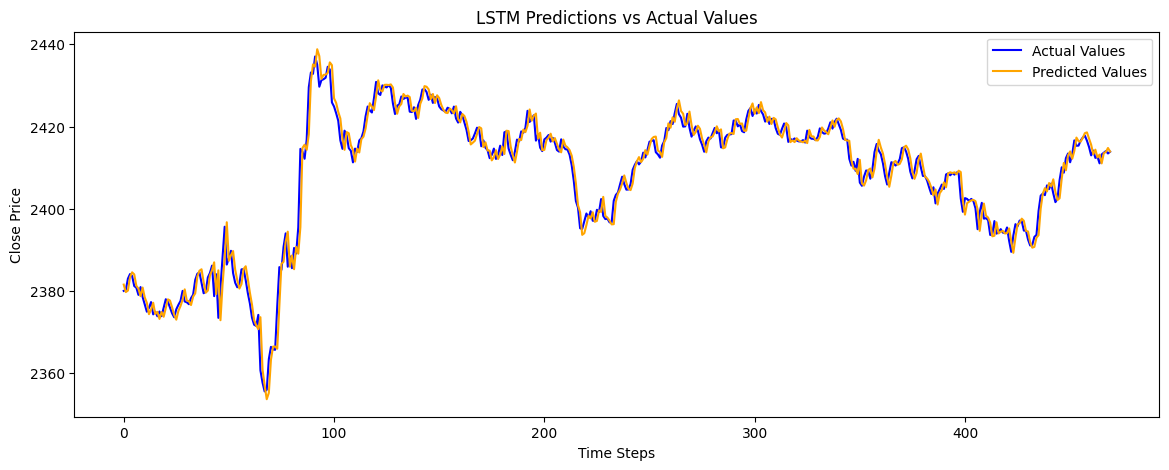

In [23]:
predictions_mean = predictions[:, 0]
predictions_full = np.zeros((predictions_mean.shape[0], number_of_features))

predictions_full[:, 3] = predictions_mean.flatten()
predictions_full[:, :3] = 0
predictions_full[:, 4:] = 0

predictions_inverse = scaler.inverse_transform(predictions_full)

y_test_full = np.zeros((target_values.shape[0], number_of_features))
y_test_full[:, 3] = target_values
y_test_inverse = scaler.inverse_transform(y_test_full)

mse = mean_squared_error(y_test_inverse[:, 3], predictions_inverse[:, 3])
print(f"Mean Squared Error: {mse}")
plt.figure(figsize=(14, 5))
plt.plot(y_test_inverse[:, 3], label='Actual Values', color='blue')
plt.plot(predictions_inverse[:, 3], label='Predicted Values', color='orange')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.show()

### **: Calculate Performance Metrics to evaluate the model**

In [24]:
rmse = np.sqrt(mean_squared_error(y_test_inverse[:, 3], predictions_inverse[:, 3]))
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 2.827949990530086


In [25]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test_inverse[:, 3], predictions_inverse[:, 3])
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 2.012090502789686


In [26]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test_inverse[:, 3], predictions_inverse[:, 3])
print(f"R² Score: {r2}")

R² Score: 0.9699595226483264


In [27]:
mape = np.mean(np.abs((y_test_inverse[:, 3] - predictions_inverse[:, 3]) / y_test_inverse[:, 3])) * 100
print(f"Mean Absolute Percentage Error: {mape}%")

Mean Absolute Percentage Error: 0.08367055121106538%
